## Домашняя работа 2

### Поляков Григорий M05-115a

В данной работе рассматривается графовый рекоммендательный алгоритм из статьи [Graph Convolutional Matrix Completion
](https://arxiv.org/pdf/1706.02263v2.pdf)

#### Краткое описание алгоритма

Дана разреженная матрица оценок пользователями товараов размера $(N_u, N_v)$, где $N_u$ - количество пользователей, $N_v$ - количество товаров. Наблюдаемые оценки - числа {1, ..., r}, ненаблюдаемые отмечены нулем. Требуется по наблюдаемым значениям восстановаить ненаблюдаемые.

Для этого представим данные в виде графа $(\mathcal{W}, \mathcal{E}, \mathcal{R})$ c вершинами пользователей $\mathcal{U}$ и товаров $\mathcal{V}$. $\mathcal{U} \cup \mathcal{V} = \mathcal{W}$. Каждое ребро представим в виде $(u_i, r, v_i)$, где $r \in \mathcal{R}$ - рейтинг.

Модель будет представлять из себя графовый автоэнкодер. Он будет состоять из:
1) Энкодера $Y = f(X, A)$, который на вход принимает эмбеддинги всех вершин графа $X = N \times D$, матрицу смежности $A$ и выдает эмбеддинги $Y = N \times E$. 
2) Декодера $\hat{A} = g(Y)$, который по эмбеддингам энкодера получает предсказания значений в матрице смежности.

В статье матрица смежности $A$, которая содержит в себе дискретные рейтинги в качестве весов, представляется в виде one-hot $A = [M_1, ..., M_r]$, где каждая бинарная матрица $M_i$ отвечает за свой рейтинг.

В качестве энкодера рассматривается графовая сверточная сеть, которая в каждой вершине суммирует эмбеддинги соседей с некоторыми коэффициентами

$$\mu_{j \rightarrow i, r} = \frac{1}{c_{i, j}} W_r x_{j}$$

Здесь $x_{j}$ - эмбеддинг соседа $j$. Для каждого значения рейтинга у нас будет своя свертка, за которую отвечает матрица весов $W_r$. $c_{i, j} = \sqrt{N_i N_j}$ - симметричный нормировочный коэффициент, зависящий от числа соседей вершины. 

Затем просуммируем для каждой вершины эмбеддинги, получившиеся после сверток и применим нелинейность.

$$h_i = \sigma \left( sum(\sum_{j \in N_{i, 1}} \mu_{j \rightarrow i, 1}, ...,  \sum_{j \in N_{i, r}} \mu_{j \rightarrow i, r})\right)$$

После, но все еще на этапе энкодера, авторы предлагают применить простой линейный слой с нелинейностью для каждой вершины. Причем веса могут быть различными для вершин товаров и пользователей.

$$u_i = \sigma(W h_i)$$

В качестве декодера авторы рассматривают билинейное преобразование с матрицами весов $Q_r$. Вероятности каждого рейтинга:

$$p\left(M_{ij} = r\right) = \frac{e^{u_i^T Q_r v_j}}{\sum_{s \in R} e^{u_i^T Q_s v_j}}$$



#### Загрузим данные

Для начала попробуем воспроизвести результаты статьи на датасете [MovieLens 100K](https://grouplens.org/datasets/movielens/100k/)

#### Скачаем датасет

In [80]:
## from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from random import sample
import matplotlib.pyplot as plt
from IPython import display

import torch
import numpy as np

from scipy.sparse import csr_matrix
import h5py

url = 'https://files.grouplens.org/datasets/movielens/ml-100k.zip'
request = urlopen(url)

with ZipFile(BytesIO(request.read())) as zip_ref:
    zip_ref.extractall('./')

#### Построим по данным матрицу смежности графа

Оценки пользователями фильмов лежат в файле `u.data`

In [81]:
data = pd.read_csv('./ml-100k/u.data', sep='\t', 
                   header=None, 
                   names=['user', 'item', 'rating', 'timestamp'], 
                   encoding = 'latin-1')
data.head()

,user,item,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


Информация о пользователях и фильмах в файлах `u.item` и `u.user`

In [82]:
movie_data = pd.read_csv('./ml-100k/u.item', sep=r'|', header=None, encoding = 'latin-1')
user_data = pd.read_csv('./ml-100k/u.user', sep=r'|', header=None, encoding = 'latin-1')
num_users = user_data.shape[0]
num_items = movie_data.shape[0]

print(f'Number of users: {num_users}')
print(f'Number of films: {num_items}')

Number of users: 943
Number of films: 1682


В данном датафрейме лежит список ребер рассматриваемого графа.
Разделим его на трейн и валидацию

In [83]:
train, val = train_test_split(data[['user', 'item', 'rating']].values, test_size=0.2, random_state=42)
train = torch.tensor(train, dtype=torch.long)
val = torch.tensor(val, dtype=torch.long)
print(f'Number of edges in train: {train.shape[0]}')
print(f'Number of edges in val: {val.shape[0]}')

Number of edges in train: 80000
Number of edges in val: 20000


Составим по списку ребер 5 матриц смежности, где в $i$-й матрице элемент $(j, k)$ будет равен 1, если пользователь $j$ поставил фильму $k$ оценку $i$.

In [84]:
def make_adj_matrix(num_users, num_items, edges_list, num_classes=5):
    adj_matrix = torch.zeros(num_users, num_items, dtype=torch.long)
    adj_matrix[edges_list[:, 0]-1, edges_list[:, 1]-1] = edges_list[:, 2]
    
    adj_matrices_class = []
    for cl in range(1, num_classes+1):
        adj_matrix_class = torch.zeros(num_users, num_items)
        adj_matrix_class[adj_matrix == cl] = 1
        adj_matrices_class.append(adj_matrix_class)
    return torch.stack(adj_matrices_class, 0)

In [85]:
train_adj_matr = make_adj_matrix(num_users, num_items, train)
val_adj_matr = make_adj_matrix(num_users, num_items, val)

#### Имплементируем основной алгоритм

In [86]:
class MessagePassing(torch.nn.Module):
    def __init__(self, num_classes, embedding_dim, hidden_dim):
        super(MessagePassing, self).__init__()
        self.num_classes = num_classes
        self.embedding_dim = embedding_dim
        
        # применение линейного слоя для каждого типа рейтинга перед message passing (W_r)
        self.rating_linear = torch.nn.Parameter(torch.Tensor(num_classes, embedding_dim, embedding_dim))
        self.playlist_song_linear = torch.nn.Parameter(torch.Tensor(2, embedding_dim, hidden_dim))
        torch.nn.init.normal_(self.rating_linear, std=0.1)
        torch.nn.init.normal_(self.playlist_song_linear, std=0.1)
        
        self.relu = torch.nn.ReLU()
    
    def normalize(self, mx):
        # применение симметричной нормализации в зависимости от числа соседей перед message passing
        # основано на имплементации сверточных графовых сетей
        rowsum = torch.sum(mx, 0)
        r_inv = torch.pow(rowsum, -0.5)
        r_inv[torch.isinf(r_inv)] = 0.
        r_mat_inv = torch.diag(r_inv)
        colsum = torch.sum(mx, 1)
        c_inv = torch.pow(colsum, -0.5)
        c_inv[torch.isinf(c_inv)] = 0.
        c_mat_inv = torch.diag(c_inv)

        output = torch.matmul(mx, r_mat_inv)
        output = torch.matmul(c_mat_inv, mx)
        return output
    
    def forward(self, playlist_embeddings, song_embeddings, playlists, songs, adj_matrices):
        assert self.num_classes == adj_matrices.shape[0]
        
        all_playlist_embeddings = []
        all_song_embeddings = []
        for i in range(adj_matrices.shape[0]):
            # для каждого типа рейтинга производим свой message passing
            adj_matrix = adj_matrices[i]
            norm = self.normalize(adj_matrix)
            playlist_norms = norm[playlists]
            song_norms = norm.T[songs]
            
            # преобразовываем эмбеддинг каждой ноды и складываем с нормализованными весами
            new_playlist_embeddings = playlist_norms @ (song_embeddings @ self.rating_linear[i])
            new_song_embeddings = song_norms @ (playlist_embeddings @ self.rating_linear[i])
            
            all_playlist_embeddings.append(new_playlist_embeddings)
            all_song_embeddings.append(new_song_embeddings)
        
        # суммируем эмбеддинги для по всем классам
        all_playlist_embeddings = torch.stack(all_playlist_embeddings, 0).sum(0)
        all_song_embeddings = torch.stack(all_song_embeddings, 0).sum(0)
        
        # линейное преобразование эмбедддингов пользователей и товаров по одтельности
        all_playlist_embeddings = self.relu(all_playlist_embeddings @ self.playlist_song_linear[0])
        all_song_embeddings = self.relu(all_song_embeddings @ self.playlist_song_linear[0])

        return all_playlist_embeddings, all_song_embeddings


class Decoder(torch.nn.Module):
    def __init__(self, num_classes, embedding_dim):
        super(Decoder, self).__init__()
        self.embedding_dim = embedding_dim
        self.num_classes = num_classes
        
        # билинейное преобразование эмбеддингов пользователей и товаров в зависимости от класса
        self.bilinear_operator = torch.nn.Parameter(torch.Tensor(self.num_classes,
                                                                 self.embedding_dim,
                                                                 self.embedding_dim))
        torch.nn.init.normal_(self.bilinear_operator, std=0.1)
        
    def forward(self, playlist_features, song_features):
        output = []
        for i in range(self.num_classes):
            output.append(playlist_features @ self.bilinear_operator[i] @ song_features.T)
        return torch.stack(output, 0)

    
class GAE(torch.nn.Module):
    def __init__(self, num_playlists, num_songs, num_classes,
                 embedding_dim, hidden_dim, dropout=0.7):
        super(GAE, self).__init__()
        self.num_playlists = num_playlists
        self.num_songs = num_songs
        self.embedding_dim = embedding_dim
        self.num_classes = num_classes
        
        # начальное приближение эмбеддингов нод пользователей и товаров
        self.playlist_embeddings = torch.nn.Parameter(torch.Tensor(self.num_playlists, self.embedding_dim))
        self.song_embeddings = torch.nn.Parameter(torch.Tensor(self.num_songs, self.embedding_dim))
        torch.nn.init.normal_(self.playlist_embeddings, std=0.1)
        torch.nn.init.normal_(self.song_embeddings, std=0.1)
        
        # энкодер и декодер
        self.graph_conv = MessagePassing(num_classes, embedding_dim, hidden_dim)
        self.decoder = Decoder(num_classes, hidden_dim)
        self.softmax =  torch.nn.Softmax(dim=0)
    
    def forward(self, playlists, songs, adj_matrix):
        playlist_embeddings, song_embeddings = self.graph_conv(self.playlist_embeddings, self.song_embeddings,
                                                               playlists, songs, adj_matrix)
        scores = self.decoder(playlist_embeddings, song_embeddings)
        scores = self.softmax(scores)
        return scores, self.ratings_from_scores(scores)
    
    def ratings_from_scores(self, scores):
        ratings = torch.stack([(r+1)*rating_score 
                               for r, rating_score in enumerate(scores)], 0)
        ratings = torch.sum(ratings, 0)
        return ratings
    
    def predict(self, playlist):
        playlist_emb = self.playlist_embeddings[playlist].unsqueeze(0)
        scores = self.decoder(playlist_emb, self.song_embeddings)
        scores = self.softmax(scores)
        print(scores.shape)
        return self.ratings_from_scores(scores)

#### Лосс, метрики и пайплайн обучения

In [87]:
def rmse(preds, target):
    labels = torch.max(target, 0)[1].float() + 1.
    
    valid_edges = target.sum(dim=0)
    nonzero = torch.nonzero(valid_edges)
    
    mse = (valid_edges * (labels - preds)**2).sum() / len(nonzero)
    rmse = torch.sqrt(mse)
    return rmse


def loss(probs, target):
    probs = probs.reshape(probs.shape[0], -1).T
    target = target.reshape(target.shape[0], -1).T

    valid_edges = target.sum(dim=1)
    nonzero = len(torch.nonzero(valid_edges))
    target = target.max(dim=1)[1]

    loss = torch.nn.functional.cross_entropy(input=probs, target=target,
                                             reduction='none')
    loss = torch.sum(torch.mul(valid_edges, loss)) / nonzero
    return loss


def train(model, adj_matrix, num_playlists, num_songs, optim):
    model.train()
    optim.zero_grad()
    probs, predictions = model(torch.tensor(range(num_playlists)),
                               torch.tensor(range(num_songs)),
                               adj_matrix.clone())
    
    curr_loss = loss(probs, adj_matrix.detach())
    curr_rmse = rmse(predictions, adj_matrix)
    curr_loss.backward()
    optim.step()
    return curr_loss, curr_rmse

def evaluate(model, adj_matrix, num_playlists, num_songs):
    model.eval()
    u = torch.tensor(range(num_playlists))
    v = torch.tensor(range(num_songs))
    
    probs, predictions = model(u, v, adj_matrix.clone())
    return loss(probs, adj_matrix), rmse(predictions, adj_matrix)

In [102]:
def plot(train_losses, val_losses, train_rmses, val_rmses):
    plt.figure(figsize=(8, 3))
    plt.subplot(121)
    plt.plot(train_losses, label='train')
    plt.plot(val_losses, label='val')
    plt.legend()
    plt.title('Loss')
    plt.subplot(122)
    plt.plot(train_rmses, label='train')
    plt.plot(val_rmses, label='val')
    plt.legend()
    plt.title('RMSE')
    plt.show()

def train_loop(num_users, num_items, train_adj_matr, val_adj_matr, num_epochs=100):
    model = GAE(num_users, num_items, train_adj_matr.shape[0], 50, 10)
    optim = torch.optim.Adam(model.parameters(), lr=1e-2)

    train_losses = []
    train_rmses = []
    val_losses = []
    val_rmses = []
    for epoch in tqdm(range(num_epochs)):
        train_loss, train_rmse = train(model, train_adj_matr,
                                       num_users, num_items, optim)
        val_loss, val_rmse = evaluate(model, val_adj_matr, num_users, num_items)
        train_losses.append(train_loss.detach().numpy())
        val_losses.append(val_loss.detach().numpy())
        train_rmses.append(train_rmse.detach().numpy())
        val_rmses.append(val_rmse.detach().numpy())
        
        if epoch > 0 and epoch % 10 == 0:
            plot(train_losses, val_losses, train_rmses, val_rmses)
            
            display.clear_output(wait=True)
    return train_losses, val_losses, train_rmses, val_rmses

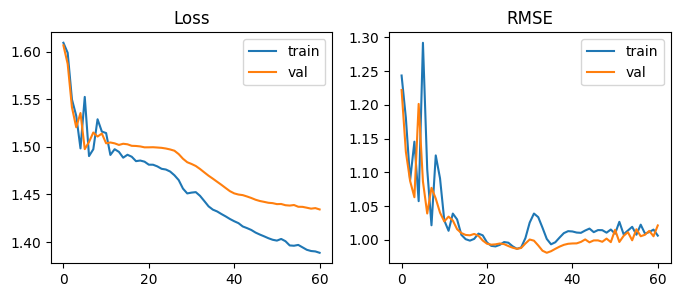

In [103]:
train_losses, val_losses, train_rmses, val_rmses = train_loop(num_users, num_items,
                                                              train_adj_matr, val_adj_matr,
                                                              num_epochs=61)
plot(train_losses, val_losses, train_rmses, val_rmses)

In [104]:
print(f'Best val RMSE: {min(val_rmses)}')

Best val RMSE: 0.9809784889221191


Получили RMSE ~0.976 без дополнительных признаков и дропаута, использованных в статье. Это уже лучше бейзлайнов, с которыми сравнивались в статье.
Результат статьи: RMSE ~0.91

#### Поэксперементируем теперь с музыкальным рекоммендательным датасетом

In [105]:
# из https://github.com/fmonti/mgcnn
def load_matlab_file(path_file, name_field):
    """
    load '.mat' files
    inputs:
        path_file, string containing the file path
        name_field, string containig the field name (default='shape')
    warning:
        '.mat' files should be saved in the '-v7.3' format
    """
    db = h5py.File(path_file, 'r')
    ds = db[name_field]
    print(ds)
    try:
        if 'ir' in ds.keys():
            data = np.asarray(ds['data'])
            ir   = np.asarray(ds['ir'])
            jc   = np.asarray(ds['jc'])
            out  = sp.csc_matrix((data, ir, jc)).astype(np.float32)
    except AttributeError:
        # Transpose in case is a dense matrix because of the row- vs column- major ordering between python and matlab
        out = np.asarray(ds).astype(np.float32).T

    db.close()

    return out

Загрузим данные, обычно используемые в литературе. Они уже разделены на трейн и тест

In [106]:
path_dataset = './yahoo_music/training_test_dataset_10_NNs.mat'
# рейтинги
all_ratings = load_matlab_file(path_dataset, 'M')
# ребра для обучения
train_edges = load_matlab_file(path_dataset, 'Otraining')
# ребра для теста
test_edges = load_matlab_file(path_dataset, 'Otest')

<HDF5 dataset "M": shape (3000, 3000), type "<f8">
<HDF5 dataset "Otraining": shape (3000, 3000), type "<f8">
<HDF5 dataset "Otest": shape (3000, 3000), type "<f8">


In [107]:
print(f'Unique ratings: {np.unique(all_ratings)}')
print(f'Num of unique ratings: {len(np.unique(all_ratings))}')

Unique ratings: [  0.   1.   4.   6.  10.  11.  13.  16.  17.  19.  20.  23.  25.  28.
  30.  31.  32.  34.  36.  39.  40.  41.  42.  43.  44.  47.  49.  50.
  52.  53.  54.  58.  59.  60.  61.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  98.
  99. 100.]
Num of unique ratings: 72


Можем видеть, что в данных 72 уникальных типа оценок. 
Преобразуем их в 10 и сделаем последовательными.

In [136]:
all_ratings_converted = all_ratings // 10
print(f'Unique ratings: {np.unique(all_ratings_converted)}')
print(f'Num of unique ratings: {len(np.unique(all_ratings_converted))}')

Unique ratings: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
Num of unique ratings: 11


In [140]:
train_ratings = torch.tensor(all_ratings_converted * train_edges)
test_ratings = torch.tensor(all_ratings_converted * test_edges)

In [141]:
def make_one_hot(rating_matrix, num_ratings):
    one_hot = torch.zeros((num_ratings, rating_matrix.shape[0], rating_matrix.shape[1]))
    for rating in range(1, num_ratings+1):
        one_hot[rating-1][rating_matrix == rating] = 1
    return one_hot

train_adj_music = make_one_hot(train_ratings, 10)
test_adj_music = make_one_hot(test_ratings, 10)

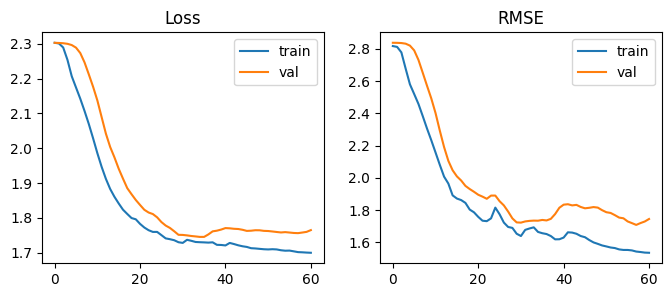

In [142]:
train_losses, val_losses, train_rmses, val_rmses = train_loop(train_ratings.shape[0], 
                                                              train_ratings.shape[1],
                                                              train_adj_music,
                                                              test_adj_music,
                                                              num_epochs=61)
plot(train_losses, val_losses, train_rmses, val_rmses)